In [1]:
import numpy as np
import pandas as pd

from scipy import stats
import itertools
from sklearn import linear_model
from numpy import ones,vstack
from numpy.linalg import lstsq
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import statsmodels.api as sm;

pd.options.display.max_columns = 150;

Ture = True;

In [2]:
from sklearn import ensemble;
from sklearn.preprocessing import LabelEncoder

In [3]:
typedict = {#'PID' : 'nominal',
            'SalePrice' : 'Continuous',
            #Matt
            'LotFrontage' : 'Continuous', 
            'LotArea' : 'Continuous',
            'maybe_LotShape' : 'Nominal',
            'LandSlope' : 'Nominal', 
            'LandContour' : 'Nominal', 
            'maybe_MSZoning' : 'Nominal', 
            'Street_paved' : 'Nominal', 
            'Alley' : 'Nominal',
            'Neighborhood' : 'Nominal', 
            'Foundation' : 'Nominal',
            'Utilities' : 'Nominal',
            'Heating' : 'Nominal',
            'HeatingQC_nom' : 'Ordinal',
            'CentralAir' : 'Nominal',
            'Electrical' : 'Nominal',
            'HeatingQC_ord' : 'Ordinal',
            'LotShape_com' : 'Nominal',
            'MSZoning_com' : 'Nominal',
            'LF_Near_NS_RR' : 'Nominal',
            'LF_Near_Positive_Feature' : 'Nominal',
            'LF_Adjacent_Arterial_St' : 'Nominal',
            'LF_Near_EW_RR' : 'Nominal',
            'LF_Adjacent_Feeder_St' : 'Nominal',
            'LF_Near_Postive_Feature' : 'Nominal',
            'Heating_com' : 'Nominal',
            'Electrical_com' : 'Nominal',
            'LotConfig_com' : 'Nominal', 
            'LotFrontage_log' : 'Continuous',
            'LotArea_log' : 'Continuous',
            #Oren 
            'MiscFeature': 'Nominal',
            'Fireplaces': 'Discrete',
            'FireplaceQu': 'Ordinal',
            'PoolQC': 'Ordinal',
            'PoolArea': 'Continuous',
            'PavedDrive': 'Nominal',
            'ExterQual': 'Ordinal',
            'OverallQual': 'Ordinal',
            'maybe_OverallCond': 'Ordinal',
            'MiscVal': 'Continuous',
            'YearBuilt': 'Discrete',
            'YearRemodAdd': 'Discrete',
            'KitchenQual': 'Ordinal',
            'Fence': 'Ordinal',
            'RoofStyle': 'Nominal',
            'RoofMatl': 'Nominal',
            'maybe_ExterCond': 'Ordinal',
            'maybe_MasVnrType': 'Nominal',
            'MasVnrArea': 'Continuous',
            #Mo
            'BsmtQual_ord': 'Ordinal',
            'BsmtCond_ord': 'Ordinal',
            'BsmtExposure_ord': 'Ordinal',
            'TotalBsmtSF': 'Continuous',
            'BSMT_GLQ':'Continuous', 
            'BSMT_Rec':'Continuous',
            'maybe_BsmtUnfSF': 'Continuous',
            'maybe_BSMT_ALQ':'Continuous',
            'maybe_BSMT_BLQ':'Continuous', 
            'maybe_BSMT_LwQ':'Continuous', 
            #Deck
            'WoodDeckSF':'Continuous', 
            'OpenPorchSF':'Continuous', 
            'ScreenPorch':'Continuous',
            'maybe_EnclosedPorch':'Continuous',
            'maybe_3SsnPorch':'Continuous',
            #Garage
            'GarageFinish':'Nominal', 
            'GarageYrBlt':'Continuous',
            'GarageCars':'Ordinal',
            'GarageArea':'Continuous',
            'GarageType_con':'Nominal',
            'maybe_GarageQual':'Nominal', 
            'maybe_GarageCond':'Nominal',

            # Hao-Wei
            "SaleType": "Nominal",
            "BldgType": "Nominal",
            "Functional_ord": "Ordinal", # Changed from "Functional"
            "1stFlrSF": "Continuous",
            "2ndFlrSF": "Continuous",
            "maybe_LowQualFinSF": "Continuous", # Rejectable p-value
            "GrLivArea": "Continuous",
            "BsmtFullBath": "Discrete",
            "maybe_BsmtHalfBath": "Discrete", # Rejectable p-value
            "FullBath": "Discrete",
            "maybe_HalfBath": "Discrete",
            "BedroomAbvGr": "Discrete",
            "KitchenAbvGr": "Discrete",
            "TotRmsAbvGrd": "Discrete",
            "MoSold": "Discrete", # Rejectable p-value
            "YrSold": "Discrete", # Rejectable p-value
            "1stFlrSF_log": "Continuous",
            "2ndFlrSF_log": "Continuous",
            "GrLivArea_log": "Continuous",
            "number_floors": "Discrete",
            "attic": "Ordinal",
            "PUD": "Nominal",
            #### Whose?
            "SaleCondition": "Nominal",
            "SalePrice_log": "Continuous",
            "MS_coded": "Nominal",
            "sold_datetime": "Discrete",
    
            # Used locally in this notebook
            "Months_Elapsed": "Discrete"
}

In [4]:
attic_dict = {"No attic": 0, "Finished": 2, "Unfinished": 1};
fence_dict = {"No Fence": 0, "Minimum Privacy": 3, "Good Privacy": 4, "Good Wood": 2 , "Minimum Wood/Wire": 1};
PoolQC_dict = {0:0, "0":0, "Fa": 1, "TA":2, "Gd":3, "Ex":4};

In [5]:
housing = pd.read_csv('../data/ames_housing_price_data_v2.csv', index_col = 0);

In [6]:
y = housing["SalePrice"];
ylog = housing["SalePrice_log"];

x = housing.drop(["SalePrice", "SalePrice_log"], axis = 1);
x = x.fillna(0);

In [7]:
# Drop the column sold_datetime and replace with a column which computes the time elapsed since 2006-01.
# I don't like sold_datetime much, and sklearn often have difficulty understanding it.

x.drop("sold_datetime", axis = 1, inplace = True);
x["Months_Elapsed"] = 12*(x["YrSold"]-2006) + x["MoSold"];
x["attic"] = x.apply(lambda t: attic_dict[t["attic"]], axis = 1);
x["Fence"] = x.apply(lambda t: fence_dict[t["Fence"]], axis = 1);
x["PoolQC"] = x.apply(lambda t: PoolQC_dict[t["PoolQC"]], axis = 1);

x.drop("HeatingQC_nom", axis = 1, inplace = True);

In [8]:
col_num = [w for w in x.columns if typedict[w] in ["Continuous", "Discrete", "Ordinal"]];
col_nom = [w for w in x.columns if typedict[w] == "Nominal"];
# TODO: Not avery ordinal variables are in the machine understandable way.
# Fix: HeatingQC_nom, Fence, attic

x_num = x[col_num];
x_nom = x[col_nom];

In [9]:
# Encode all nominal and ordinal variables.

lencoder = LabelEncoder();

temp = pd.DataFrame({"SalePrice": y});
for col_name in col_nom:
    # temp = lencoder.fit_transform(np.array(str(x[[col_name]])).reshape(-1,1));
    temp[col_name] = np.array(lencoder.fit_transform(x[col_name].astype(str))).reshape(-1,1);
    
temp.drop("SalePrice", axis = 1, inplace = True);

In [10]:
x = pd.concat([x_num, temp], axis = 1);

In [12]:
# Setting up random forest regression
GBR = ensemble.GradientBoostingRegressor();
GBR.set_params(random_state=0);

GBR.fit(x, ylog);

In [13]:
GBR.score(x, ylog)

0.9551827419801764

In [14]:
feature_importance = pd.DataFrame({"Features": x.columns, "Importance":GBR.feature_importances_});

In [15]:
feature_importance.sort_values("Importance", ascending = False, inplace=True);
feature_importance.head()

,Features,Importance
3,OverallQual,0.400432
0,GrLivArea,0.087465
55,GrLivArea_log,0.081567
5,YearBuilt,0.065966
11,TotalBsmtSF,0.053001


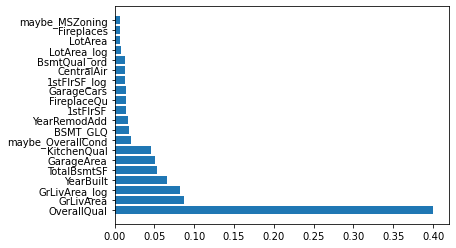

In [16]:
temp = feature_importance.iloc[:20,]
plt.barh(temp["Features"], temp["Importance"]);

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, ylog, test_size=0.3, random_state=0);


GBR.fit(x_train, y_train);

In [18]:
print("The super overfitting train score: %.4f" %GBR.score(x_train, y_train));
print("The super screwed up test score:   %.4f" %GBR.score(x_test, y_test));

The super overfitting train score: 0.9606
The super screwed up test score:   0.9022
